# Bay Area Bike Share Analysis

## Introduction

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

In this project, I have performed an exploratory analysis on the data. I have performed two of the major parts of the data analysis process: data wrangling and exploratory data analysis. Before getting started, I asked myself some questions: if I were working for Bay Area Bike Share, what kinds of information I would want to know about in order to make smarter business decisions? If I were a user of the bike share service, what factors might influence how I would want to use the service?

**Questions can be answered by this analysis**:

Question 1 : What is the most attractive cities in Bay area for tourists? To answer this question, I explored the popularity of stations for the people with 3-day or 24-hour passes to pick up and return bikes. 

Question 2 : In which locations the Bike Share Company should add more stations and docks? For example, if we can infer from the data that most of the yearly subscribers use the bike to go to work, then the Bike Share Company should add more stations and docks in the area where more business and companies locate. Moreover, for the locations that attract the tourists most, the company should also consider to add more stations and docks.


> **Note**:<br /> 
(1) This block of text is written using [Markdown](http://daringfireball.net/projects/markdown/syntax), which is a way to format text using headers, links, italics, and many other options.<br />
(2) In 2014, Bay Area Bike Share held an [Open Data Challenge](http://www.bayareabikeshare.com/datachallenge-2014) to encourage data analysts to create visualizations based on their open data set. The winner of this challenge is Tyler Field ([link to Tyler's analysis](http://thfield.github.io/babs/index.html)).

## Data Wrangling

Now it's time to explore the data. The data is stored in the data folder. The data comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. I started by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. The code below takes the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).


In [1]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [2]:
# file locations
file_in  = 'data/201402_trip_data.csv'
file_out = 'data/201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader) # datarow is a list of string, each string is an attribute for this record
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step is to look at the structure of the dataset to see if there's any data wrangling we should perform. The below cell reads in the sampled data file that created in the previous cell, and print out the first few rows of the table.

In [5]:
sample_data = pd.read_csv('data/201309_trip_data.csv')
display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, I concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. I also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. The below code cell shows how the station information is structured, then creates the station-city mapping. The station mapping is set up as a function, `create_station_mapping()`. Since it is possible that more stations are added or dropped over time, this function allows us to combine the station information across all three parts of our data when we are ready to explore everything.

In [7]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('data/201402_station_data.csv')
display(station_info.head())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Input: station_data is a list of file path;
    Output: create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data: 
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


We can use the mapping to condense the trip data. This is performed in the `summarise_data()` function below. As part of this function, the `datetime` module is used to **parse** the timestamp strings from the original data file as datetime objects (`strptime`), which can then be output in a different string format (`strftime`). The parsed objects also have a variety of attributes and methods to quickly obtain.


In [9]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments are lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.weekday()
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point) #write a dict each

In [11]:
# Process the data by running the function wrote above.
station_data = ['data/201402_station_data.csv']
trip_in = ['data/201309_trip_data.csv']
trip_out = 'data/201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,3,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,3,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,3,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,3,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,3,San Francisco,San Francisco,Subscriber


All counts are as expected!


C:\Users\Xin\Desktop\Xin_Mu_Study\Git-repo\git-fast\data-science-projects\1-bike-share-analysis\babs_visualizations.py:68: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  duration_qtiles = data['duration'].quantile([.25, .5, .75]).as_matrix()



## Exploratory Data Analysis

Now that you have some data saved to a file, let's look at some initial trends in the data. Some code has already been written for you in the `babs_visualizations.py` script to help summarize and visualize the data; this has been imported as the functions `usage_stats()` and `usage_plot()`. In this section we'll walk through some of the things you can do with the functions, and you'll use the functions for yourself in the last part of the project. First, run the following cell to load the data, then use the `usage_stats()` function to see the total number of trips made in the first month of operations, along with some statistics regarding how long trips took.

In [5]:
trip_data = pd.read_csv('201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

You should see that there are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration (the point where 50% of trips are shorter, and 50% are longer). In fact, the mean is larger than the 75% shortest durations. This will be interesting to look at later on.

Let's start looking at how those trips are divided by subscription type. One easy way to build an intuition about the data is to plot it. We'll use the `usage_plot()` function for this. The second argument of the function allows us to count up the trips across a selected variable, displaying the information in a plot. The expression below will show how many customer and how many subscriber trips were made. Try it out!

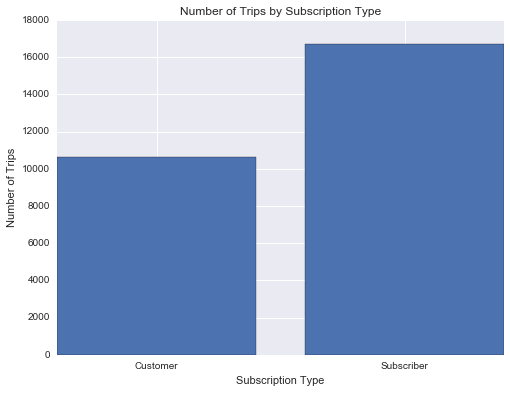

In [6]:
usage_plot(trip_data, 'subscription_type')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. What does the distribution of trip durations look like?

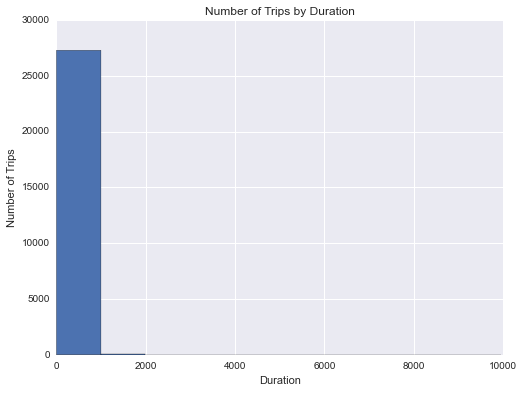

In [10]:
usage_plot(trip_data, 'duration')

Looks pretty strange, doesn't it? Take a look at the duration values on the x-axis. Most rides are expected to be 30 minutes or less, since there are overage charges for taking extra time in a single trip. The first bar spans durations up to about 1000 minutes, or over 16 hours. Based on the statistics we got out of `usage_stats()`, we should have expected some trips with very long durations that bring the average to be so much higher than the median: the plot shows this in a dramatic, but unhelpful way.

When exploring the data, you will often need to work with visualization function parameters in order to make the data easier to understand. Here's where the third argument of the `usage_plot()` function comes in. Filters can be set for data points as a list of conditions. Let's start by limiting things to trips of less than 60 minutes.

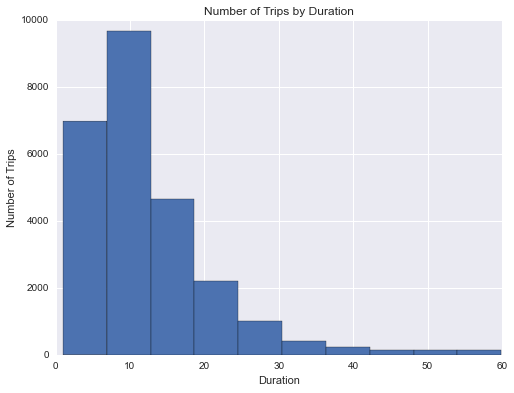

In [14]:
usage_plot(trip_data, 'duration', ['duration < 60'])

This is looking better! You can see that most trips are indeed less than 30 minutes in length, but there's more that you can do to improve the presentation. Since the minimum duration is not 0, the left hand bar is slighly above 0. We want to be able to tell where there is a clear boundary at 30 minutes, so it will look nicer if we have bin sizes and bin boundaries that correspond to some number of minutes. Fortunately, you can use the optional "boundary" and "bin_width" parameters to adjust the plot. By setting "boundary" to 0, one of the bin edges (in this case the left-most bin) will start at 0 rather than the minimum trip duration. And by setting "bin_width" to 5, each bar will count up data points in five-minute intervals.

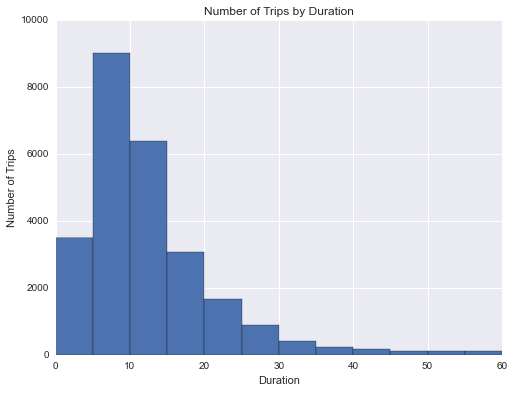

In [15]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

**Question 4**: Which five-minute trip duration shows the most number of trips? Approximately how many trips were made in this range?

**Answer**: 

5-10 minite trip duration shows the most number of trips. Approximately 9000 trips were made in this range.

Visual adjustments like this might be small, but they can go a long way in helping you understand the data and convey your findings to others.

## Performing Your Own Analysis

Now that you've done some exploration on a small sample of the dataset, it's time to go ahead and put together all of the data in a single file and see what trends you can find. The code below will use the same `summarise_data()` function as before to process data. After running the cell below, you'll have processed all the data into a single data file. Note that the function will not display any output while it runs, and this can take a while to complete since you have much more data than the sample you worked with above.

In [10]:
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

Since the `summarise_data()` function has created a standalone file, the above cell will not need to be run a second time, even if you close the notebook and start a new session. You can just load in the dataset and then explore things from there.

In [11]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,3,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,3,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,3,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,3,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,3,San Francisco,San Francisco,Subscriber


#### Now it's your turn to explore the new dataset with `usage_stats()` and `usage_plot()` and report your findings! Here's a refresher on how to use the `usage_plot()` function:
- first argument (required): loaded dataframe from which data will be analyzed.
- second argument (required): variable on which trip counts will be divided.
- third argument (optional): data filters limiting the data points that will be counted. Filters should be given as a list of conditions, each element should be a string in the following format: `'<field> <op> <value>'` using one of the following operations: >, <, >=, <=, ==, !=. Data points must satisfy all conditions to be counted or visualized. For example, `["duration < 15", "start_city == 'San Francisco'"]` retains only trips that originated in San Francisco and are less than 15 minutes long.

If data is being split on a numeric variable (thus creating a histogram), some additional parameters may be set by keyword.
- "n_bins" specifies the number of bars in the resultant plot (default is 10).
- "bin_width" specifies the width of each bar (default divides the range of the data by number of bins). "n_bins" and "bin_width" cannot be used simultaneously.
- "boundary" specifies where one of the bar edges will be placed; other bar edges will be placed around that value (this may result in an additional bar being plotted). This argument may be used alongside the "n_bins" and "bin_width" arguments.

You can also add some customization to the `usage_stats()` function as well. The second argument of the function can be used to set up filter conditions, just like how they are set up in `usage_plot()`.

In [12]:
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

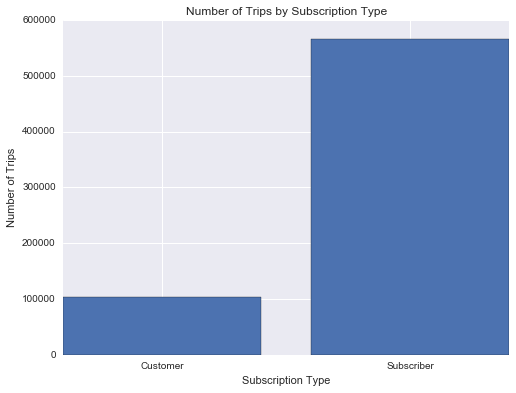

In [13]:
usage_plot(trip_data,'subscription_type')

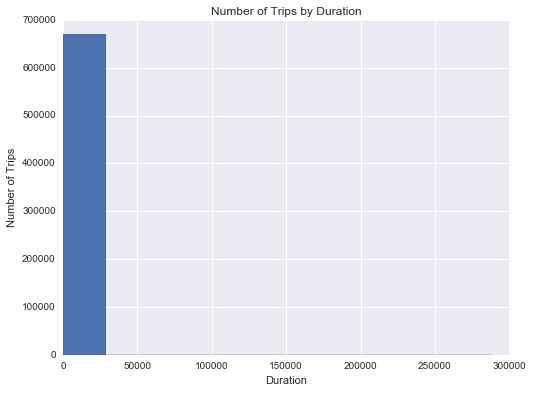

In [14]:
usage_plot(trip_data,'duration')

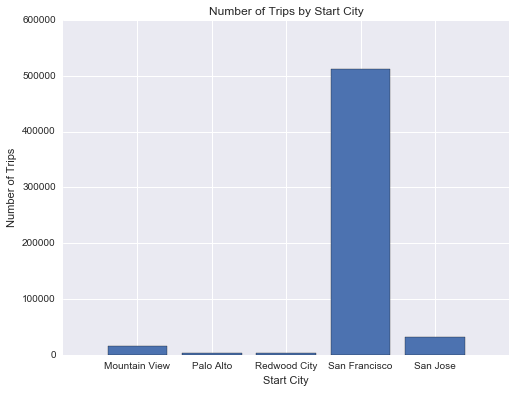

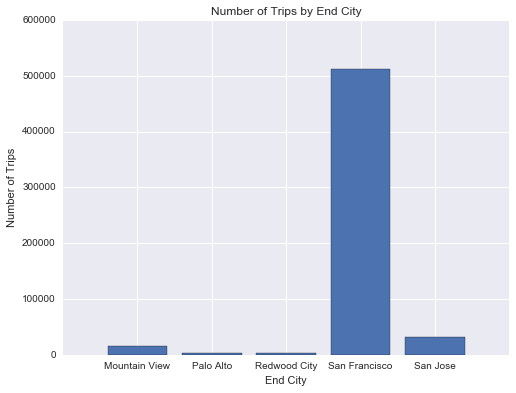

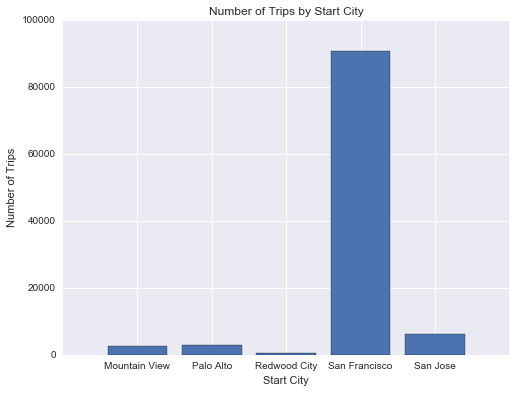

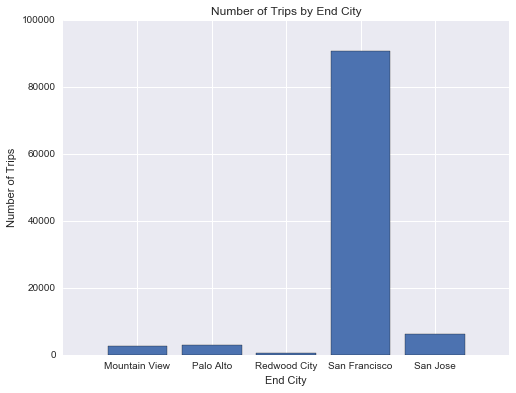

In [26]:
usage_plot(trip_data,'start_city', ["subscription_type == 'Subscriber'"])
usage_plot(trip_data,'end_city', ["subscription_type == 'Subscriber'"])
usage_plot(trip_data,'start_city', ["subscription_type == 'Customer'"])
usage_plot(trip_data,'end_city', ["subscription_type == 'Customer'"])


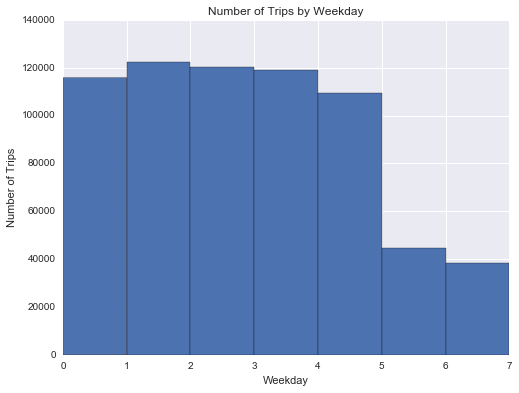

In [21]:
usage_plot(trip_data,'weekday',boundary = 0, bin_width = 1)

Explore some different variables using the functions above and take note of some trends you find. Feel free to create additional cells if you want to explore the dataset in other ways or multiple ways.

> **Tip**: In order to add additional cells to a notebook, you can use the "Insert Cell Above" and "Insert Cell Below" options from the menu bar above. There is also an icon in the toolbar for adding new cells, with additional icons for moving the cells up and down the document. By default, new cells are of the code type; you can also specify the cell type (e.g. Code or Markdown) of selected cells from the Cell menu or the dropdown in the toolbar.

One you're done with your explorations, copy the two visualizations you found most interesting into the cells below, then answer the following questions with a few sentences describing what you found and why you selected the figures. Make sure that you adjust the number of bins or the bin limits so that they effectively convey data findings. Feel free to supplement this with any additional numbers generated from `usage_stats()` or place multiple visualizations to support your observations.

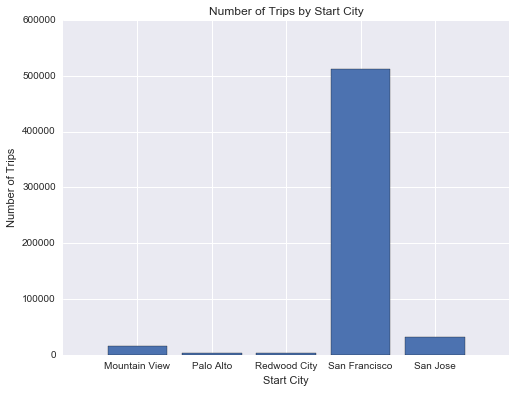

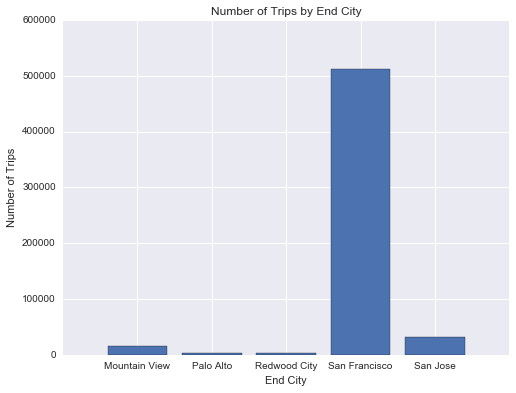

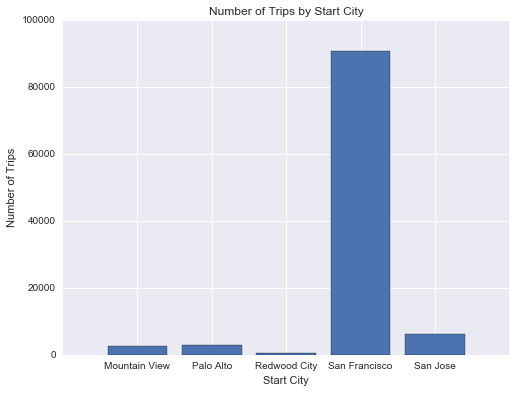

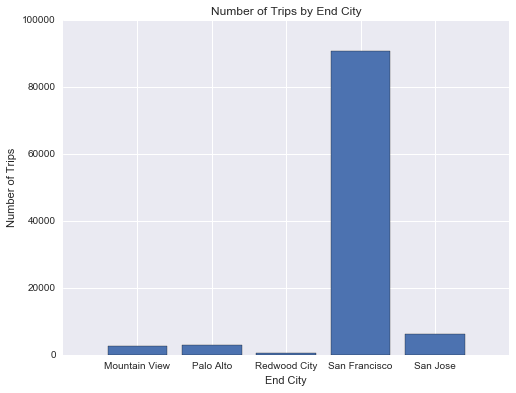

In [27]:
# Final Plot 1
usage_plot(trip_data,'start_city', ["subscription_type == 'Subscriber'"])
usage_plot(trip_data,'end_city', ["subscription_type == 'Subscriber'"])
usage_plot(trip_data,'start_city', ["subscription_type == 'Customer'"])
usage_plot(trip_data,'end_city', ["subscription_type == 'Customer'"])

**Question 5a**: What is interesting about the above visualization? Why did you select it?

**Answer**: 

From these visualiztions, I find SF is the most popular city for both tourists and commuters. It is easy to undertand that the tourists are most attracted to SF among all the cities. For the local people, they use the bike to go to work and head home. So it also makes sense that the stations in SF have more usage than those in other cities, because SF is a big city and has more business and residences. 

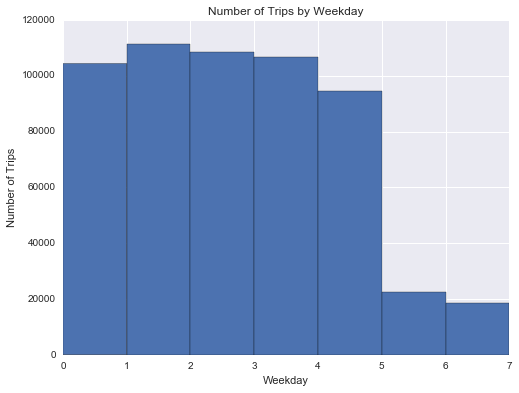

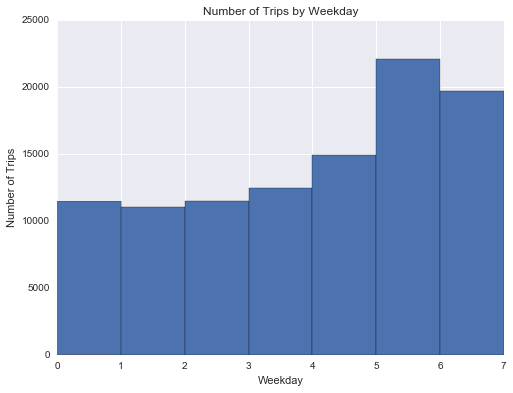

In [28]:
# Final Plot 2
usage_plot(trip_data,'weekday', ["subscription_type == 'Subscriber'"],boundary = 0, bin_width = 1)
usage_plot(trip_data,'weekday', ["subscription_type == 'Customer'"], boundary = 0, bin_width = 1)


**Question 5b**: What is interesting about the above visualization? Why did you select it?

**Answer**: 

From these 2 visualizations, we can see that, for the subscribers, the usage of the bike in weekday is much more than that in weekend, which means the subscriber mainly use the bike to go to work. On the other hand, for the customers, they use the bikes more in the weekend. This could be explained as that people are more likely to travel in weekend, because they do not need to work in weekend.   

## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about our data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the code given. Instead of just looking at number of trips on the outcome axis, you could see what features affect things like trip duration. We also haven't looked at how the weather data ties into bike usage.

**Question 6**: Think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: 

I'd like to apply the data science technique to study and imporve the movie or music recommendation system. We can get a huge amount of data from the Movie website such as Netflix. We can analyze the data, and provide more accurate and personalized recmmendation service, which would make the customers happy and also would improve the revenue of the company.

For the recommendation system, deep learning is the core technique. I can learn some deep learning from this subject, which is very cool.

> **Tip**: If we want to share the results of our analysis with others, we aren't limited to giving them a copy of the jupyter Notebook (.ipynb) file. We can also export the Notebook output in a form that can be opened even for those without Python installed. From the **File** menu in the upper left, go to the **Download as** submenu. You can then choose a different format that can be viewed more generally, such as HTML (.html) or
PDF (.pdf). You may need additional packages or software to perform these exports.